In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

In [3]:
from sqlalchemy import create_engine  # connecting to local postgres database

In [15]:
engine = create_engine("postgresql://postgres@db/postgres")

raw_data = pd.read_sql_query(
    """
    SELECT 
        *, 
        date_trunc('day', datetime) as date,
        AVG("close") OVER(PARTITION BY symbol ORDER BY datetime ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS close5,
        AVG("close") OVER(PARTITION BY symbol ORDER BY datetime ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) AS close10
    FROM stocks_5m_rth 
    WHERE datetime > '2019-05-01' AND datetime < '2019-06-01'
    AND symbol IN ('TSLA', 'AMZN', 'CAR', 'GOOGL', 'AAPL', 'MSFT', 'BAC', 'BA', 'C', 'DB')
    ORDER BY datetime
    """,
    con=engine,
)

trading_days = raw_data.date.unique()
trading_symbols = raw_data.symbol.unique()


# AND symbol IN ('TSLA', 'AMZN', 'CAR', 'GOOGL', 'AAPL', 'MSFT', 'BAC', 'BA', 'C', 'DB')
# raw_data
# print(trading_days)
print(trading_symbols)

['C' 'BA' 'MSFT' 'TSLA' 'AAPL' 'CAR' 'DB' 'GOOGL' 'BAC' 'AMZN']


In [5]:
print(trading_symbols)

['C' 'BA' 'MSFT' 'TSLA' 'AAPL' 'CAR' 'DB' 'GOOGL' 'BAC' 'AMZN']


In [16]:
def getmydata(myday, mysymbol):
    ts_data = raw_data[(raw_data["date"] == myday) & (raw_data["symbol"] == mysymbol)]
    ts_data = ts_data.reset_index(
        drop=True
    )  # This changes the index to a contiguous range starting from 0
    return ts_data


# test this function --> success
# getmydata("2020-01-21", "AAPL")
# ts_price = getmydata("2020-01-21", "AAPL")
myday = "2019-05-20"
mysymbol = "AAPL"
ts_price = getmydata(myday, mysymbol)
ts_price

,symbol,datetime,open,high,low,close,volume,date,close5,close10
0,AAPL,2019-05-20 09:30:00,183.630,183.99,181.3100,181.3670,2661163.0,2019-05-20,187.42348,188.11974
1,AAPL,2019-05-20 09:35:00,181.360,181.39,180.2839,181.2600,1904850.0,2019-05-20,185.87748,187.40574
2,AAPL,2019-05-20 09:40:00,181.245,181.90,180.6900,181.8032,1030681.0,2019-05-20,184.49604,186.71606
3,AAPL,2019-05-20 09:45:00,181.800,183.49,181.6300,183.1700,1187377.0,2019-05-20,183.31604,186.13306
4,AAPL,2019-05-20 09:50:00,183.140,183.18,181.8900,182.5800,874099.0,2019-05-20,182.03604,185.47706
...,...,...,...,...,...,...,...,...,...,...
73,AAPL,2019-05-20 15:35:00,182.870,183.15,182.8400,183.0800,392076.0,2019-05-20,182.79096,182.41148
74,AAPL,2019-05-20 15:40:00,183.090,183.17,182.8300,182.8600,335324.0,2019-05-20,182.84096,182.47448
75,AAPL,2019-05-20 15:45:00,182.860,183.05,182.7000,182.7700,418184.0,2019-05-20,182.88800,182.55248
76,AAPL,2019-05-20 15:50:00,182.775,183.14,182.7750,183.0900,439551.0,2019-05-20,182.93800,182.67248


In [17]:
def fit_function(timeframe):
    if timeframe < 20:
        return False
    now = timeframe + 1
    x = np.linspace(0, now + 19, num=now + 20, endpoint=True)
    x_realtime = x[now - 20 : now]
    x_realtime_odd = x_realtime[1::2]
    x_realtime_even = x_realtime[::2]
    y = ts_price["close"]
    y_realtime = y[now - 20 : now]
    y_realtime_odd = y_realtime[1::2]
    y_realtime_even = y_realtime[::2]
    # print(x_realtime_odd)
    ff = interpolate.InterpolatedUnivariateSpline(x_realtime_odd, y_realtime_odd, k=5)
    return ff

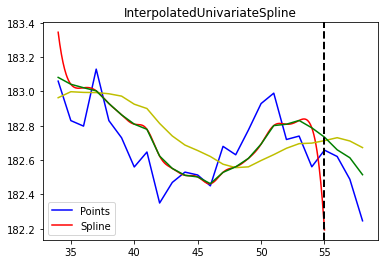

In [19]:
# timeframe = 35
# Think about now = timeframe + 1 if you want the opening price
now = timeframe
x = np.linspace(0, now + 19, num=now + 20, endpoint=True)
x_realtime = x[now - 20 : now]
x_realtime_odd = x_realtime[1::2]
x_realtime_even = x_realtime[::2]
y = ts_price["close"]
ysmooth10 = ts_price["close10"]
ysmooth5 = ts_price["close5"]
y_realtime = y[now - 20 : now]
y_realtime_odd = y_realtime[1::2]
y_realtime_even = y_realtime[::2]
# print(x_realtime_odd)
# ff = interpolate.InterpolatedUnivariateSpline(x_realtime_even, y_realtime_even, k=4)

ff = interpolate.InterpolatedUnivariateSpline(x_realtime, ysmooth5[now - 20 : now], k=4)
ff_derivative = ff.derivative()

xnew = np.linspace(now - 21, now, num=500, endpoint=True)
ynew = ff(xnew)
yderivative = ff_derivative(xnew)
thisfigure = plt.figure()
plt.plot(
    x[now - 21 : now + 4],
    y[now - 21 : now + 4],
    "b",
    xnew,
    ynew,
    "r",
    x[now - 21 : now + 4],
    ysmooth10[now - 21 : now + 4],
    "y",
    x[now - 21 : now + 4],
    ysmooth5[now - 21 : now + 4],
    "g",
)
plt.axvline(now, linewidth=2, color="black", linestyle="--")
plt.legend(["Points", "Spline"])
plt.title("InterpolatedUnivariateSpline")
plt.show()

In [21]:
from scipy import optimize
from scipy.misc import derivative

timeframe = 55
now = timeframe
x = np.linspace(0, now + 19, num=now + 20, endpoint=True)
y = ts_price["close"]
ysmooth10 = ts_price["close10"]
ysmooth5 = ts_price["close5"]


def test_func_affine(x, m, k):
    return m * x + k


def test_func_sin(x, a, b, c):
    return a * np.sin(b * x + c)


def test_func_wave(x, a, b, c, d):
    return a * np.sin(b * x + c) + d


# def test_func(x, a, b, c, d, m, k):
#   return m * x + k + a * np.sin(b * x + c) + d


affineparams, affineparams_covariance = optimize.curve_fit(
    test_func_affine,
    x[now - 20 : now],
    ysmooth5[now - 20 : now],
    p0=[1, 1],
)

yresidual5 = ysmooth5[now - 20 : now] - test_func_affine(
    x[now - 20 : now], affineparams[0], affineparams[1]
)

residualparams, residualparams_covariance = optimize.curve_fit(
    test_func_wave,
    x[now - 10 : now],
    yresidual5.tail(10),
    p0=[0.1, 0.05, 1, 0],
    maxfev=100000,
)


# print(waveparams, affineparams, residualparams)
print(affineparams, residualparams)


# def fitted_sin(x):
#   myvalue = test_func(x, params[0], params[1], params[2], params[3])
#   return myvalue


# print(derivative(fitted_sin, 35, dx=1e-6))

[-1.39894286e-02  1.83358623e+02] [-2.22195022e-01  4.22676593e-01 -1.77034734e+01 -1.45321392e-02]


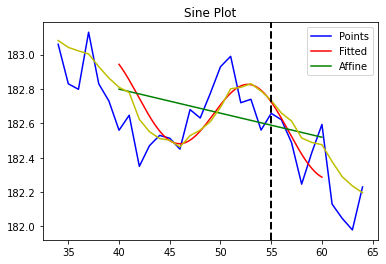

In [22]:
xaffine = np.linspace(now - 15, now + 5, num=200, endpoint=True)
xresidual = np.linspace(now - 15, now + 5, num=200, endpoint=True)
yaffine = test_func_affine(xaffine, affineparams[0], affineparams[1])
yresidual = test_func_wave(
    xresidual,
    residualparams[0],
    residualparams[1],
    residualparams[2],
    residualparams[3],
)
yresidual = yresidual + yaffine

thisfigure = plt.figure()
plt.plot(
    x[now - 21 : now + 10],
    y[now - 21 : now + 10],
    "b",
    xresidual,
    yresidual,
    "r",
    xaffine,
    yaffine,
    "g",
    x[now - 21 : now + 10],
    ysmooth5[now - 21 : now + 10],
    "y",
)
plt.axvline(now, linewidth=2, color="black", linestyle="--")
plt.legend(["Points", "Fitted", "Affine"])
plt.title("Sine Plot")
plt.show()

In [26]:
def fitted_derivative(timeframe):
    def fitted_sin(x):
        myvalue = test_func(x, params[0], params[1], params[2], params[3])
        return myvalue

    now = timeframe
    params, params_covariance = optimize.curve_fit(
        test_func,
        x[now - 15 : now - 1],
        ysmooth[now - 15 : now - 1],
        p0=[2, 0.5, 5, 182],
    )
    return derivative(fitted_sin, timeframe, dx=1e-3)

In [25]:
now = 59
print(fitted_derivative(now), shouldbuy(now), shouldsell(now))

NameError: name 'test_func' is not defined

In [253]:
def shouldbuy(timeframe):
    if timeframe < 35:
        return False
    now = timeframe
    params, params_covariance = optimize.curve_fit(
        test_func,
        x[now - 15 : now - 1],
        ysmooth[now - 15 : now - 1],
        p0=[2, 0.5, 5, 182],
    )
    return fitted_derivative(timeframe) < -0.8 * abs(params[0] * params[1])

In [254]:
def shouldsell(timeframe):
    if timeframe < 35:
        return False
    now = timeframe
    params, params_covariance = optimize.curve_fit(
        test_func,
        x[now - 15 : now - 1],
        ysmooth[now - 15 : now - 1],
        p0=[2, 0.5, 5, 182],
    )
    return fitted_derivative(timeframe) > 0.8 * abs(params[0] * params[1])

In [255]:
# Flip flop between long and short positions


def tradeonedayonesymbol(myday, mysymbol):
    ts_price = getmydata(myday, mysymbol)
    prices = []
    cash = 0
    pos = 0
    first_price = ts_price["open"][0]
    # for timeframe in [*range(len(ts_price))]:
    for timeframe in [*range(len(ts_price))]:
        print(timeframe)
        price = ts_price["open"][timeframe]
        if shouldbuy(timeframe):
            if pos == 0:
                cash = cash - price
                pos = pos + 1
            if pos < 0:
                cash = cash - 2 * price
                pos = pos + 2
        if shouldsell(timeframe):
            if pos == 0:
                cash = cash + price
                pos = pos - 1
            if pos > 0:
                cash = cash + 2 * price
                pos = pos - 2
        # print(
        #   timeframe,
        #  pos,
        # should_be_long(timeframe),
        # int(price),
        # int(cash),
        # int(cash + pos * price),
        # )
    last_price = ts_price["close"].values[-1]
    cash = cash + pos * last_price
    prices.append(pos * last_price)
    pos = 0
    # print(pos, last_price, cash)
    # print(100 * cash / last_price)
    return round(100 * cash / first_price, 2)


def tradealldaysonesymbol(daylist, symbol):
    profit = 0
    print(symbol)
    for day in daylist:
        daily_profit = tradeonedayonesymbol(day, symbol)
        profit = profit + daily_profit
        # print(day, " Daily: ", int(daily_profit), " Total to Date: ", int(profit))
    return profit


def tradeonedayallsymbols(day, symbollist):
    profit = 0
    print(day)
    for symbol in symbollist:
        symbol_profit = tradeonedayonesymbol(day, symbol)
        profit = profit + symbol_profit
        print(symbol, " Symbol Profit: ", int(symbol_profit), " Total: ", int(profit))
    return profit


def simulate(daylist, symbollist):
    overallprofit = 0
    for symbol in symbollist:
        symbol_profit = tradealldaysonesymbol(daylist, symbol)
        overallprofit = overallprofit + symbol_profit
        print(
            symbol,
            " Symbol Profit: ",
            int(symbol_profit),
            " Overall Profit: ",
            int(overallprofit),
        )
    return overallprofit

In [256]:
tradeonedayonesymbol("2019-05-22", "AAPL")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

## tradeonedayonesymbol("2019-05-22", "AAPL")